In [2]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-dzfrbvn0
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-dzfrbvn0
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test theo tỉ lệ 8:2**

In [3]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [4]:
# 3. Chia train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


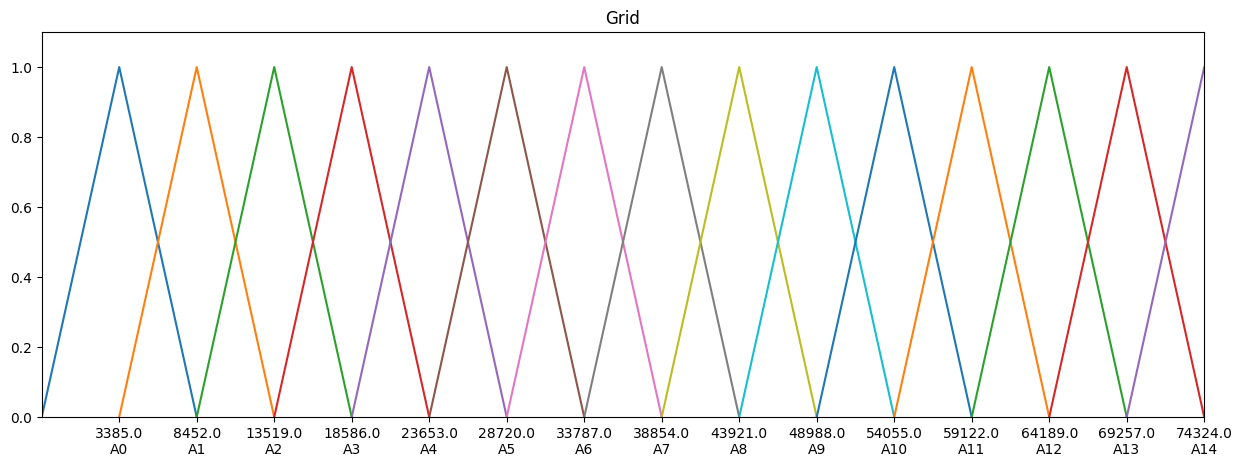

In [5]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [6]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [7]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11', 'A6 -> A4']


In [8]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A2,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A3,A1 -> A1,A2
A1,A3 -> A1,A2,A3
A2,A2 -> A0,A1,A2,A3,A4
A2,A3 -> A1,A2,A3,A4
A3,A2 -> A1,A2,A3,A4
A4,A2 -> A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A2,A4 -> A3,A4
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A3,A4,A5,A6,A7
A6,A4 -> A4,A5,A6
A4,A6 -> A5,A6
A5,A6 -> A4,A5,A6,A7
A6,A5 -> A4,A5,A6,A7
A7,A5 -> A5,A6,A7
A6,A6 -> A4,A5,A6,A7,A8
A5,A7 -> A5,A6,A7
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A6,A7,A8
A6,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A7,A8 -> A6,A7,A8,A9
A8,A7 -> A6,A7,A8,A9
A9,A7 -> A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A9 -> A10,A7,A8,A9
A9,A8 -> A10,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A9 -> A10,A11,A7,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 -> A10,A11,A8,A9
A11,A8 ->

In [9]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [10]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1285.8653133210896
Testing RMSE: 1664.61759183034
Testing MAPE: 0.03220067391230434


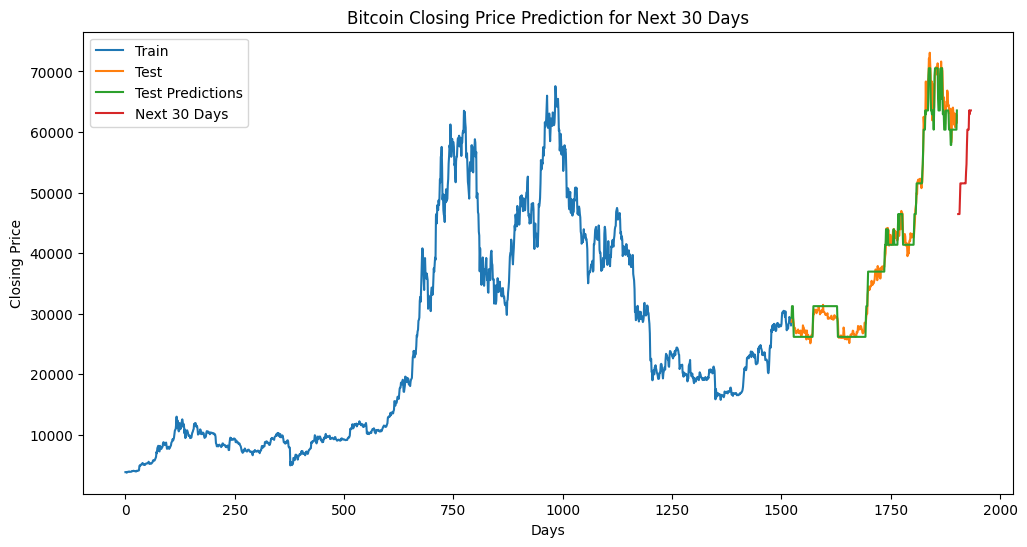

Predicted closing prices for the next 30 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838]


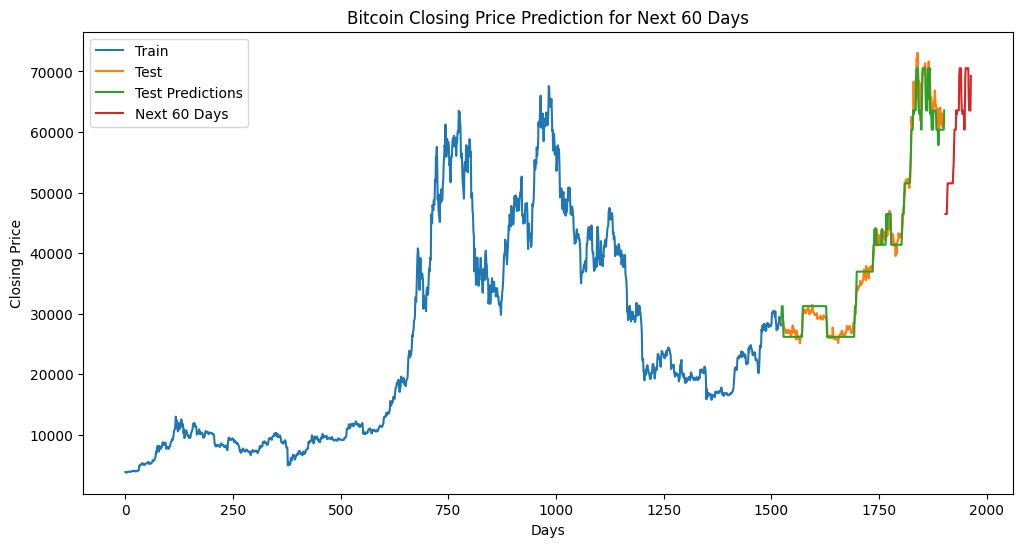

Predicted closing prices for the next 60 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965]


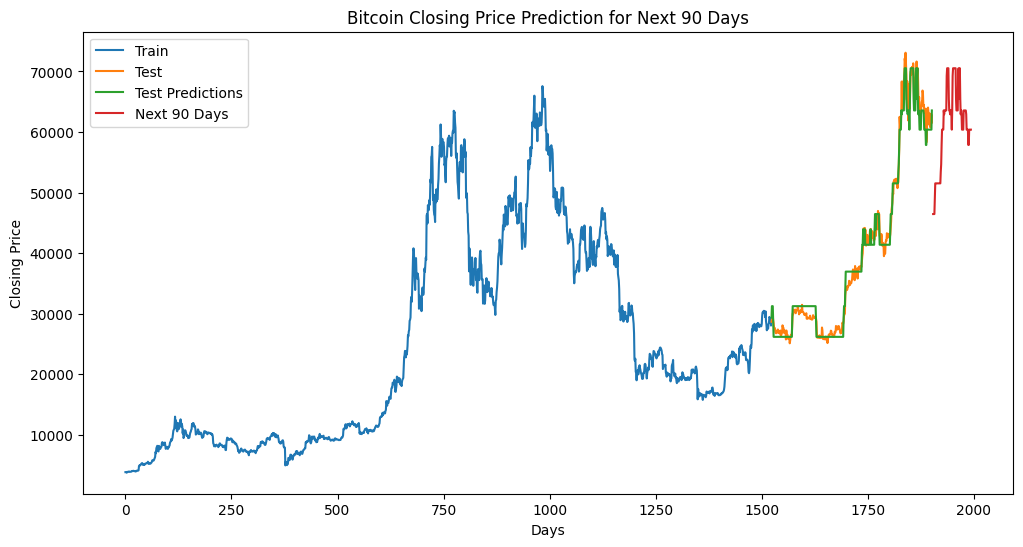

Predicted closing prices for the next 90 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965
 70523.25507549 65456.24725214 69256.5

In [11]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())


# **Chia train test theo tỉ lệ 7:3**

In [12]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [13]:
# 3. Chia train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


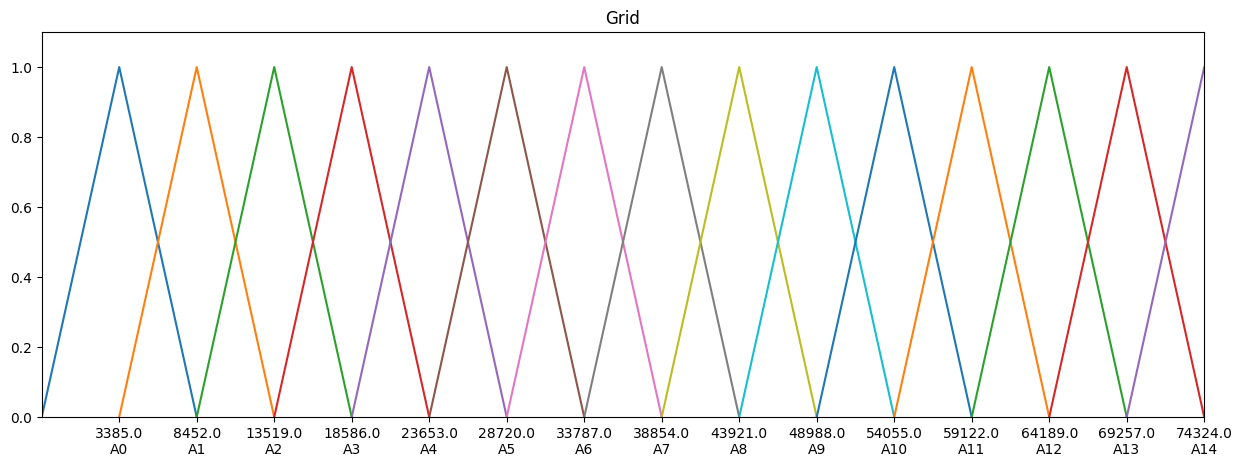

In [14]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [15]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [16]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11', 'A6 -> A4']


In [17]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A2,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A3,A1 -> A1,A2
A1,A3 -> A1,A2,A3
A2,A2 -> A0,A1,A2,A3,A4
A2,A3 -> A1,A2,A3,A4
A3,A2 -> A1,A2,A3,A4
A4,A2 -> A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A2,A4 -> A3,A4
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A3,A4,A5,A6,A7
A6,A4 -> A4,A5,A6
A4,A6 -> A5,A6
A5,A6 -> A4,A5,A6,A7
A6,A5 -> A4,A5,A6,A7
A7,A5 -> A5,A6,A7
A6,A6 -> A4,A5,A6,A7,A8
A5,A7 -> A5,A6,A7
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A6,A7,A8
A6,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A7,A8 -> A6,A7,A8,A9
A8,A7 -> A6,A7,A8,A9
A9,A7 -> A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A9 -> A10,A7,A8,A9
A9,A8 -> A10,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A9 -> A10,A11,A7,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 -> A10,A11,A8,A9
A11,A8 ->

In [18]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [19]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1173.7080493191213
Testing RMSE: 1518.1561787943294
Testing MAPE: 0.03521557772499912


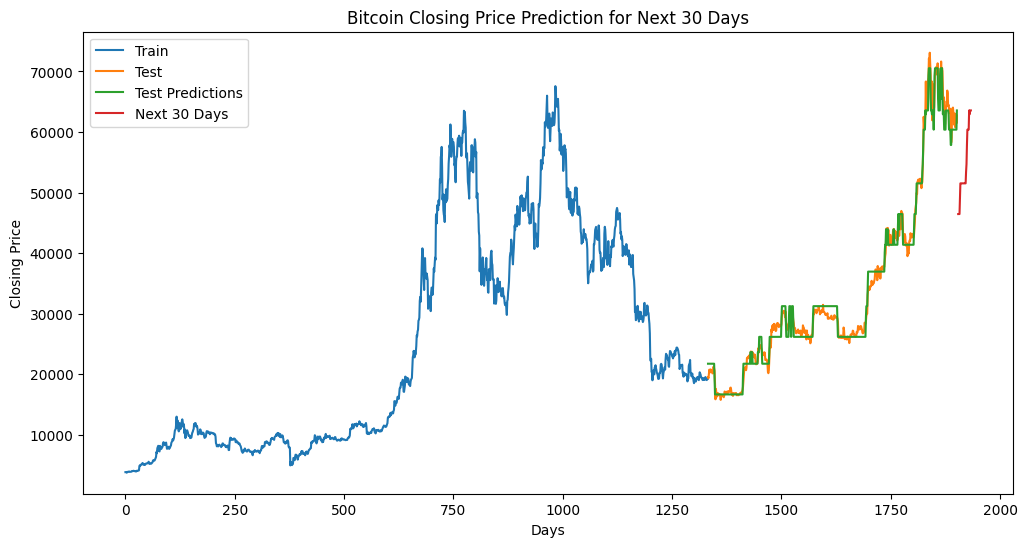

Predicted closing prices for the next 30 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838]


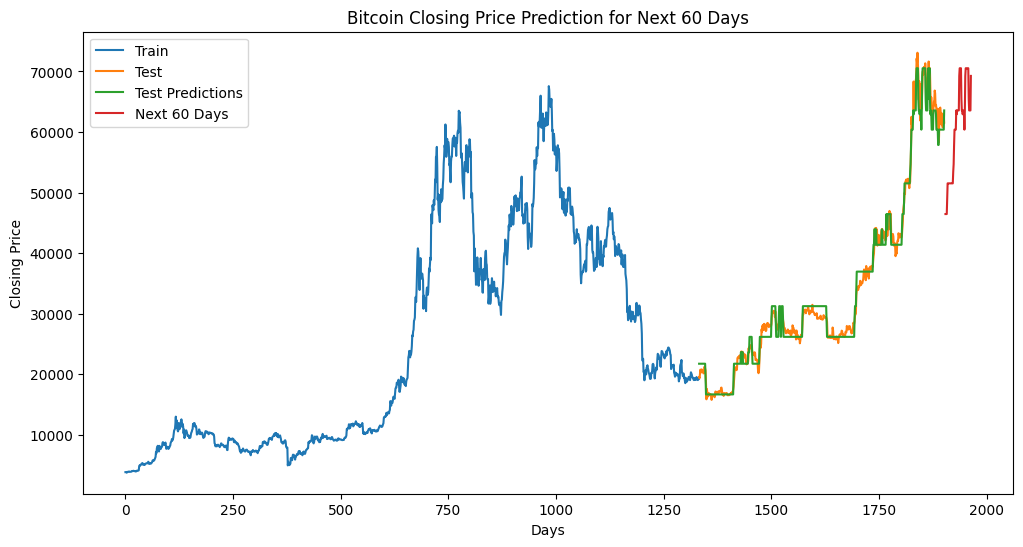

Predicted closing prices for the next 60 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965]


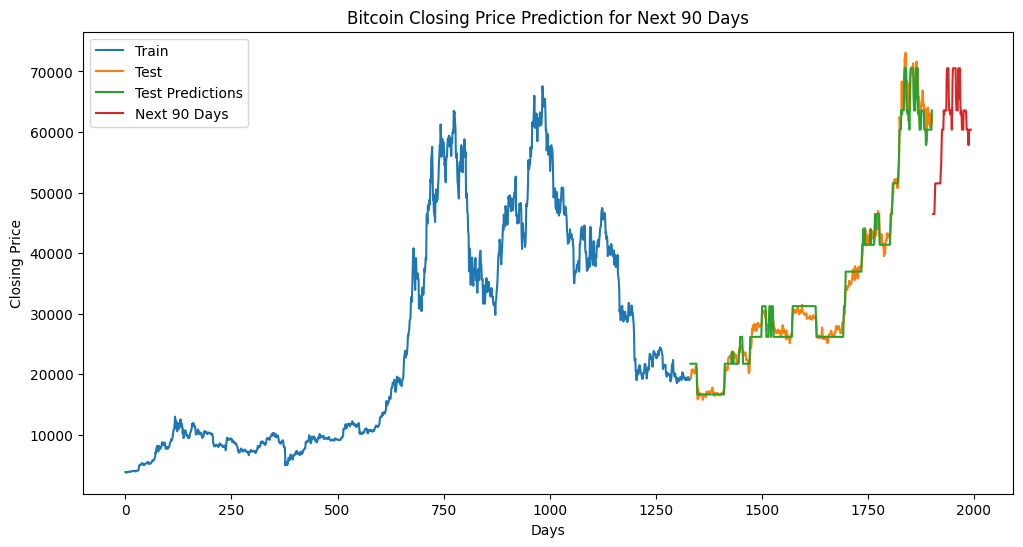

Predicted closing prices for the next 90 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965
 70523.25507549 65456.24725214 69256.5

In [20]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test theo tỉ lệ 6:4**

In [21]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [22]:
# 3. Chia train, test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


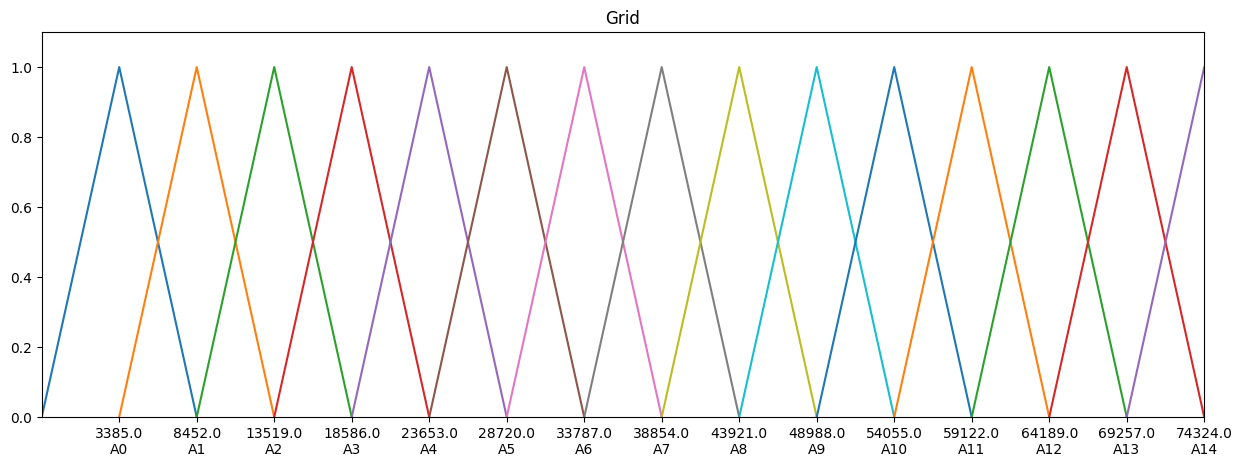

In [23]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [24]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [25]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [26]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A2,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A3,A1 -> A1,A2
A1,A3 -> A1,A2,A3
A2,A2 -> A0,A1,A2,A3,A4
A4,A2 -> A2,A3
A2,A3 -> A1,A2,A3,A4
A3,A2 -> A1,A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A2,A4 -> A3,A4
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A4,A5,A6,A7
A4,A6 -> A5,A6
A5,A6 -> A5,A6,A7
A6,A5 -> A5,A6,A7
A7,A5 -> A5,A6,A7
A5,A7 -> A5,A6,A7
A6,A6 -> A5,A6,A7,A8
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A6,A7,A8
A6,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A7,A8 -> A6,A7,A8,A9
A8,A7 -> A6,A7,A8,A9
A9,A7 -> A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A9 -> A10,A7,A8,A9
A9,A8 -> A10,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A9 -> A10,A11,A7,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 -> A10,A11,A8,A9
A11,A8 -> A10,A9
A10,A10 -> A10,A11,A12,A8

In [28]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [29]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1575.9523420309872
Testing RMSE: 2053.7712424621745
Testing MAPE: 0.05040069022863753


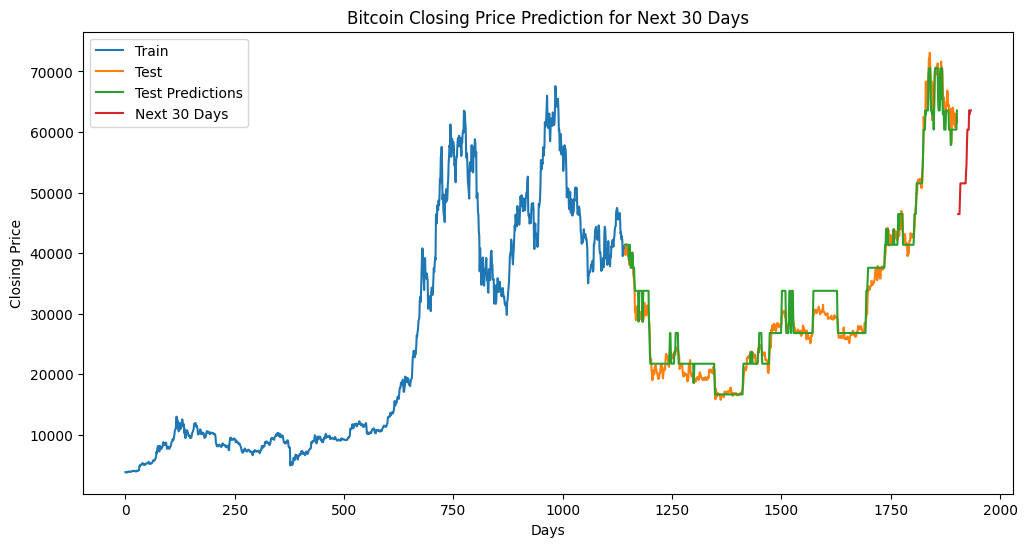

Predicted closing prices for the next 30 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838]


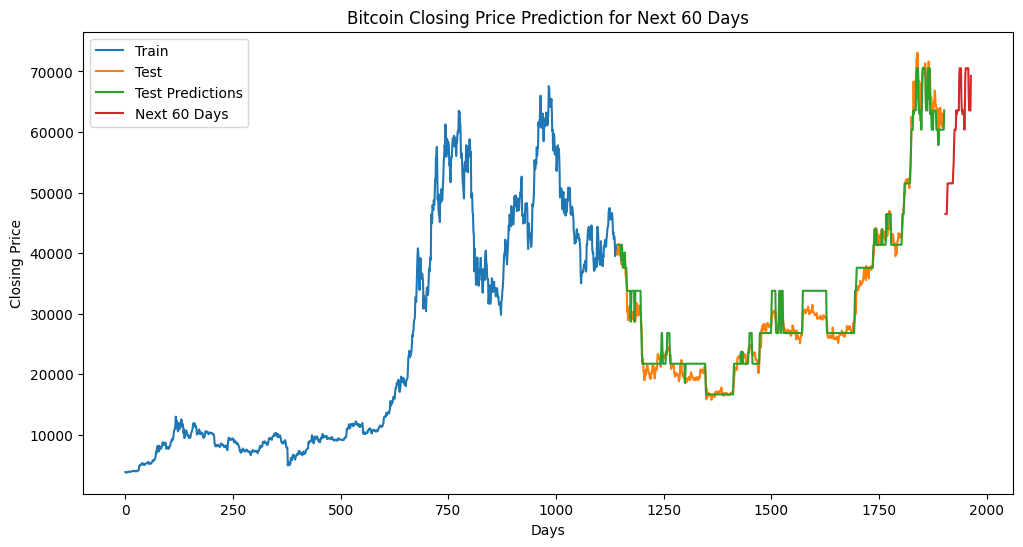

Predicted closing prices for the next 60 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965]


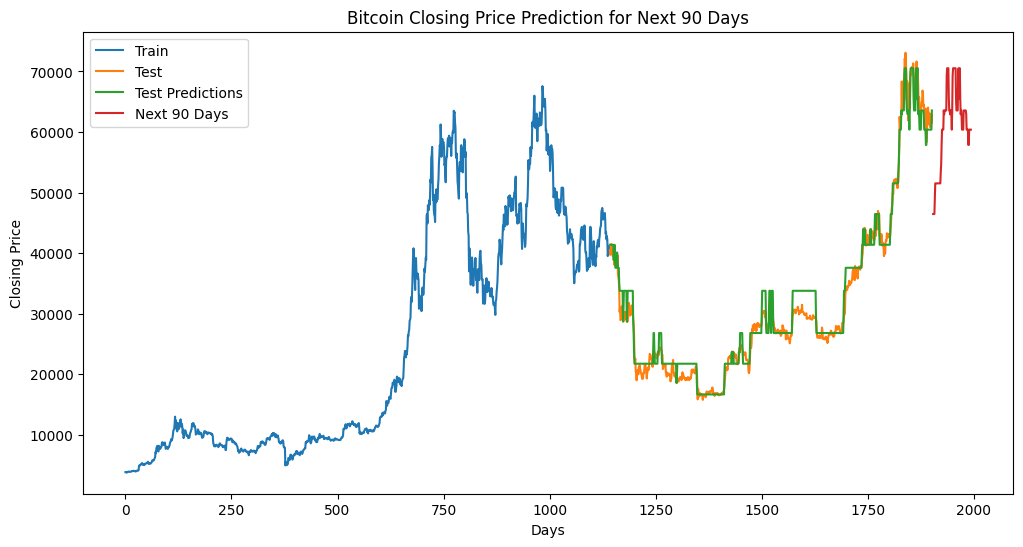

Predicted closing prices for the next 90 days:
[46454.96791458 46454.96791458 46454.96791458 46454.96791458
 48988.47182625 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 51521.97573793 51521.97573793
 51521.97573793 51521.97573793 53422.10367168 54688.85562752
 57855.73551711 60389.23942879 60389.23942879 60389.23942879
 60389.23942879 63556.11931838 62922.74334046 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 63556.11931838
 69256.50311965 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 65456.24725214 63556.11931838 63556.11931838
 62922.74334046 63556.11931838 63556.11931838 62922.74334046
 60389.23942879 63556.11931838 69256.50311965 70523.25507549
 70523.25507549 70523.25507549 70523.25507549 70523.25507549
 70523.25507549 70523.25507549 65456.24725214 63556.11931838
 63556.11931838 63556.11931838 63556.11931838 69256.50311965
 70523.25507549 65456.24725214 69256.5

In [30]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())